In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pickle
import string

/home/ebrahim/brainaudio/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Available models - uncomment the one you want to use
# MODEL_ID = "google/gemma-3-270m"
MODEL_ID = "meta-llama/Llama-3.2-3B"
#MODEL_ID = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
print(f"Loaded tokenizer: {MODEL_ID}")

Loaded tokenizer: meta-llama/Llama-3.2-3B


In [18]:
# Load training and validation transcripts
with open("/data2/brain2text/b2t_25/transcripts_train.pkl", "rb") as f:
    transcripts_train = pickle.load(f)

with open("/data2/brain2text/b2t_25/transcripts_val.pkl", "rb") as f:
    transcripts_val = pickle.load(f)

print(f"Training transcripts: {len(transcripts_train)}")
print(f"Validation transcripts: {len(transcripts_val)}")
print(f"\nSample training transcript: {transcripts_train[0] if transcripts_train else 'N/A'}")
print(f"Sample validation transcript: {transcripts_val[0] if transcripts_val else 'N/A'}")

Training transcripts: 8072
Validation transcripts: 1426

Sample training transcript: ['Bring it closer.']
Sample validation transcript: ['You can see the code at this point as well.']


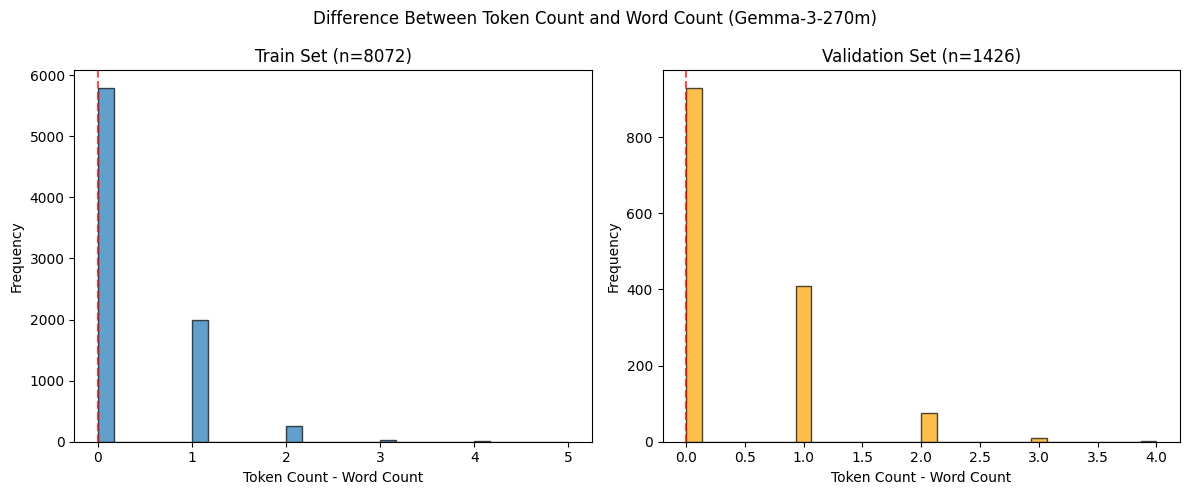

Train - Mean diff: 0.32, Min: 0, Max: 5
Val   - Mean diff: 0.42, Min: 0, Max: 4


In [19]:
import string
import matplotlib.pyplot as plt

def compute_token_word_diff(nested_sentences, tokenizer):
    """
    Computes the difference (tokens - words) for each sentence.
    Returns a list of differences.
    """
    differences = []
    
    for entry in nested_sentences:
        raw_text = entry[0]
        stripped_text = raw_text.rstrip(string.punctuation)
        
        token_ids = tokenizer.encode(stripped_text, add_special_tokens=False)
        
        word_count = len(stripped_text.split())
        token_count = len(token_ids)
        
        differences.append(token_count - word_count)
    
    return differences

# Compute differences for train and validation sets
train_diffs = compute_token_word_diff(transcripts_train, tokenizer)
val_diffs = compute_token_word_diff(transcripts_val, tokenizer)

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(train_diffs, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Token Count - Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set (n={len(train_diffs)})')
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

axes[1].hist(val_diffs, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Token Count - Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set (n={len(val_diffs)})')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

plt.suptitle('Difference Between Token Count and Word Count (Gemma-3-270m)')
plt.tight_layout()
plt.show()

print(f"Train - Mean diff: {sum(train_diffs)/len(train_diffs):.2f}, Min: {min(train_diffs)}, Max: {max(train_diffs)}")
print(f"Val   - Mean diff: {sum(val_diffs)/len(val_diffs):.2f}, Min: {min(val_diffs)}, Max: {max(val_diffs)}")